In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns   

from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, MaxAbsScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

import joblib

In [2]:
nlms = pd.read_csv('data/NLMS_PublicUse_5.1/11_new.csv', index_col='record');

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
nlms.columns

Index(['age', 'race', 'sex', 'ms', 'hisp', 'adjinc', 'educ', 'pob', 'wt',
       'hhid', 'hhnum', 'reltrf', 'occ', 'majocc', 'ind', 'majind', 'esr',
       'urban', 'smsast', 'inddea', 'cause113', 'follow', 'dayod', 'hosp',
       'hospd', 'ssnyn', 'vt', 'histatus', 'hitype', 'povpct', 'stater',
       'rcow', 'tenure', 'citizen', 'health', 'indalg', 'smok100', 'agesmk',
       'smokstat', 'smokhome', 'curruse', 'everuse'],
      dtype='object')

In [4]:
cols = ['age', 'race', 'sex', 'ms', 'hisp', 'adjinc', 'educ', 'pob',
       'wt', 'hhid', 'hhnum', 'reltrf', 'occ', 'majocc', 'ind', 'majind',
       'esr', 'urban', 'smsast', 'inddea', 'cause113', 'follow', 'dayod',
       'hosp', 'hospd', 'ssnyn', 'vt', 'histatus', 'hitype', 'povpct',
       'stater', 'rcow', 'tenure', 'citizen', 'health', 'indalg', 'smok100',
       'agesmk', 'smokstat', 'smokhome', 'curruse', 'everuse']

In [5]:
col_dict = {'index': 'record number', 'age': 'age at time of interview', 'race': 'race', 'sex': 'gender', 
            'ms': 'marital status', 'hisp': 'hispanic', 'adjinc': 'inflation adjusted income', 'educ': 'highest grade completed', 
            'pob': 'region of birth', 'wt': 'adjusted weight', 'hhid': 'household ID number', 'hhnum': 'number of people in household',
            'reltrf': 'relationship to reference person', 'occ': '4 digit occupation code', 'majocc': 'major occupation code',
            'ind': '4 digit industry code', 'majind': 'major industry code', 'esr': 'employment status recode', 
            'urban': 'urban / rural status', 'smsast': 'SMSAST (Standard Metropolitan Statistical Area) status', 'inddea': 'death indicator',
            'cause113': 'cause of death', 'follow': 'length of follow-up', 'dayod': 'day of week of death', 
            'hosp': 'hospital type', 'hosppd': 'hospital death indicator', 'ssnyn': 'presence of ssn', 
            'vt': 'veteran status', 'histatus': 'health insurance status', 'hitype': 'health insurance type', 
            'povpct': 'income as percent of poverty level', 'stater': 'state recode', 'rcow': 'recoded class of worker', 
            'tenure': 'housing tenure', 'citizen': 'citizenship', 'health': 'health', 'indalg': 'indicator of algorithmic death', 
            'smok100': 'smoked more than 100 cigarettes', 'agesmk': 'age started smoking',
            'smokstat': 'cigarette smoking status', 'smokhome': 'rules for smoking cigarettes in the home', 
            'curruse': 'currently use smokeless tobacco', 'everuse': 'ever use smokeless tobacco'}

In [6]:
lens = nlms.apply(lambda x: len(x.unique()))
lens

age             91
race             6
sex              2
ms               6
hisp             4
adjinc          15
educ            15
pob             64
wt             930
hhid        745424
hhnum           21
reltrf           7
occ            365
majocc          12
ind            229
majind          15
esr              6
urban            3
smsast           4
inddea           2
cause113       106
follow        4019
dayod            8
hosp             7
hospd            6
ssnyn            2
vt               3
histatus         3
hitype           7
povpct          21
stater          51
rcow             6
tenure           4
citizen          6
health           6
indalg           3
smok100          1
agesmk           1
smokstat         1
smokhome         1
curruse          1
everuse          1
dtype: int64

In [7]:
nlms.pob.unique()

array([909,   0, 942, 928, 917, 925, 104, 111, 934, 945, 936, 944, 107,
       927, 926, 948, 906, 950, 937, 911, 933, 939, 106, 109, 912, 108,
       913, 102, 949, 103, 931, 954, 951, 924, 901, 918, 938, 956, 923,
       947, 921, 101, 105, 955, 941, 953, 905, 902, 920, 915, 904, 930,
       922, 940, 932, 908, 910, 946, 935, 110, 919, 916, 929, 960])

In [8]:
pob_dict = {909: 'CT',   0: np.nan, 942: 'PA', 928: 'MS', 917: 'IL', 925: 'MA', 104: 'Western Europe', 111: 'Other NS', 934: 'NJ', 945: 'SC', 936: 'NY', 944: 'RI', 107: 'Central America',
       927: 'MN', 926: 'MI', 948: 'TX', 906: 'CA', 950: 'VT', 937: 'NC', 911: 'DC', 933: 'NH', 939: 'OH', 106: 'South America', 109: 'Island Country', 912: 'FL', 108: 'Mexico',
       913: 'GA', 102: 'Asia', 949: 'UT', 103: 'Eastern Europe', 931: 'NE', 954: 'WV', 951: 'VA', 924: 'MD', 901: 'AL', 918: 'IN', 938: 'ND', 956: 'WY', 923: 'ME',
       947: 'TN', 921: 'KY', 101: 'Africa', 105: 'North Am, Not US or Mexico', 955: 'WI', 941: 'OR', 953: 'WA', 905: 'AR', 902: 'AK', 920: 'KS', 915: 'HI', 904: 'AZ', 930: 'MT',
       922: 'LA', 940: 'OK', 932: 'NV', 908: 'CO', 910: 'DE', 946: 'SD', 935: 'NM', 110: 'Other NS', 919: 'IA', 916: 'ID', 929: 'MO', 960: 'American Samoa'}

In [9]:
print('Pre na qty: ' + str(nlms.isnull().sum() * 100 / len(nlms)))

Pre na qty: age           0.000000
race          0.157487
sex           0.000000
ms           19.684568
hisp          2.861032
adjinc        2.412385
educ         19.120231
pob           0.000000
wt            0.000000
hhid          0.000000
hhnum         0.000000
reltrf        0.254704
occ          46.609888
majocc       46.609888
ind          46.621931
majind       46.621931
esr          19.122029
urban         0.710708
smsast        0.711471
inddea        0.000000
cause113      0.000000
follow        0.000000
dayod        91.240126
hosp         91.401209
hospd        92.088921
ssnyn         0.000000
vt           21.582314
histatus     31.484596
hitype       31.484596
povpct        0.000000
stater        0.000000
rcow         46.521880
tenure        1.386703
citizen      74.667969
health       79.067361
indalg       80.994806
smok100     100.000000
agesmk      100.000000
smokstat    100.000000
smokhome    100.000000
curruse     100.000000
everuse     100.000000
dtype: float64


In [10]:
nlms.follow.value_counts(normalize=True)

4018    0.912401
3617    0.000039
2531    0.000036
3199    0.000036
3565    0.000035
          ...   
7       0.000010
478     0.000009
3       0.000007
1       0.000007
0       0.000001
Name: follow, Length: 4019, dtype: float64

In [11]:
nlms.drop(columns=['smok100', 'agesmk', 'smokstat', 'smokhome', 'curruse', 'everuse'], inplace=True)

In [12]:
nlms.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1835072 entries, 88426 to 670
Data columns (total 36 columns):
 #   Column    Dtype  
---  ------    -----  
 0   age       int64  
 1   race      float64
 2   sex       int64  
 3   ms        float64
 4   hisp      float64
 5   adjinc    float64
 6   educ      float64
 7   pob       int64  
 8   wt        int64  
 9   hhid      int64  
 10  hhnum     int64  
 11  reltrf    float64
 12  occ       float64
 13  majocc    float64
 14  ind       float64
 15  majind    float64
 16  esr       float64
 17  urban     float64
 18  smsast    float64
 19  inddea    int64  
 20  cause113  int64  
 21  follow    int64  
 22  dayod     float64
 23  hosp      float64
 24  hospd     float64
 25  ssnyn     int64  
 26  vt        float64
 27  histatus  float64
 28  hitype    float64
 29  povpct    int64  
 30  stater    int64  
 31  rcow      float64
 32  tenure    float64
 33  citizen   float64
 34  health    float64
 35  indalg    float64
dtypes: float

In [13]:
nlms.shape

(1835072, 36)

### DataFrame for deceased individuals

In [14]:
dec = nlms[nlms.dayod.isin([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0])]


In [15]:
causes_dict_ref = {1: 'Infectious Disease', 2: 'Malignant or Other Neoplasm', 3: 'Nutrition-Related', 4: 'NeuroMuscular', 
                   5: 'Cardiovascular or Circulatory', 6: 'Respiratory', 7: 'Liver or Kidney', 8: 'Pregnancy or Birth', 
                  9: 'Otherwise Unspecified', 10: 'Accidental Harm', 11: 'Intentional Harm'}
causes_dict = {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 
               18: 2, 19: 2, 20: 2, 21: 2, 22: 2, 23: 2, 24: 2, 25: 2, 26: 2, 27: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 2, 33: 2, 
               34: 2, 35: 2, 36: 2, 37: 2, 38: 2, 39: 2, 40: 2, 41: 2, 
               42: 3, 43: 3, 44: 3, 45: 3, 46: 4, 47: 4, 48: 4, 49: 5, 50: 5, 51: 5, 
               52: 5, 53: 5, 54: 5, 55: 5, 56: 5, 57: 5, 58: 5, 59: 5, 60: 5, 61: 5, 62: 5, 63: 5, 64: 5, 65: 5, 
               66: 6, 67: 6, 68: 6, 69: 6, 70: 6, 71: 6, 72: 6, 73: 6, 74: 6, 75: 6, 76: 6, 80: 7, 
               81: 7, 82: 7, 83: 7, 84: 7, 85: 7, 86: 7, 87: 7, 88: 7, 89: 7, 90: 8, 91: 8, 92: 8, 93: 8, 77: 9, 78: 9, 79: 9, 94: 9, 95: 9, 
               96: 10, 97: 10, 98: 10, 99: 10, 100: 10, 101: 10, 102: 10, 103: 10, 104: 10, 113: 10, 105: 11, 
               106: 11, 107: 11, 108: 11, 109: 11, 110: 11, 111: 11, 112: 11}

In [16]:
dec.cause113.replace(causes_dict, inplace=True)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:4515: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [17]:
dec.cause113.unique()

array([ 9,  5,  6,  2,  7, 10, 11,  3,  4,  1,  8,  0])

In [18]:
dec.shape

(160750, 36)

In [19]:
dec

,age,race,sex,ms,hisp,adjinc,educ,pob,wt,hhid,...,vt,histatus,hitype,povpct,stater,rcow,tenure,citizen,health,indalg
record,,,,,,,,,,,,,,,,,,,,,
88427,79,1.0,2,2.0,3.0,11.0,4.0,909,132,1,...,0.0,NaN,NaN,18,16,3.0,1.0,NaN,NaN,NaN
88445,66,1.0,2,5.0,3.0,2.0,5.0,909,144,8,...,0.0,NaN,NaN,3,16,NaN,2.0,NaN,NaN,1.0
88446,70,1.0,1,1.0,3.0,7.0,5.0,942,181,13,...,0.0,NaN,NaN,10,23,NaN,1.0,NaN,NaN,NaN
88452,80,1.0,1,1.0,3.0,3.0,3.0,942,132,15,...,0.0,NaN,NaN,4,23,NaN,1.0,NaN,NaN,NaN
88453,80,1.0,2,1.0,3.0,3.0,3.0,942,147,15,...,0.0,NaN,NaN,4,23,NaN,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
657,77,1.0,2,3.0,3.0,6.0,8.0,0,127,745419,...,0.0,1.0,1.0,10,16,NaN,3.0,NaN,3.0,1.0
662,46,1.0,2,1.0,2.0,1.0,8.0,0,57,745422,...,0.0,0.0,0.0,1,16,NaN,2.0,NaN,1.0,0.0
666,19,1.0,1,5.0,2.0,4.0,8.0,0,60,745423,...,0.0,1.0,4.0,6,16,2.0,2.0,NaN,1.0,NaN


In [700]:
dec.to_csv('data/dec.csv')

In [701]:
# Start over here: 
dec = pd.read_csv('data/dec.csv')

In [20]:
# Split before preprocessing
dec_label = dec.pop('age')
dec_features = dec.copy()

In [21]:
dec_features.columns

Index(['race', 'sex', 'ms', 'hisp', 'adjinc', 'educ', 'pob', 'wt', 'hhid',
       'hhnum', 'reltrf', 'occ', 'majocc', 'ind', 'majind', 'esr', 'urban',
       'smsast', 'inddea', 'cause113', 'follow', 'dayod', 'hosp', 'hospd',
       'ssnyn', 'vt', 'histatus', 'hitype', 'povpct', 'stater', 'rcow',
       'tenure', 'citizen', 'health', 'indalg'],
      dtype='object')

#### Pipeline for Processing

In [22]:
cols_to_drop = ['hhid', 'reltrf', 'occ', 'majocc', 'majind', 'ind', 'smsast', 
                'inddea', 'follow', 'hospd', 'stater', 'health', 'indalg',
               'citizen', 'rcow', 'hhnum', 'ms', 'educ', 'wt', 'esr', 'vt']

In [23]:
dec_features.drop(columns=cols_to_drop, inplace=True, axis=1);

In [26]:
dec_features

,race,sex,hisp,adjinc,pob,urban,cause113,dayod,hosp,ssnyn,histatus,hitype,povpct,tenure
record,,,,,,,,,,,,,,
88427,1.0,2,3.0,11.0,909,1.0,9,5.0,1.0,0,NaN,NaN,18,1.0
88445,1.0,2,3.0,2.0,909,1.0,5,1.0,1.0,1,NaN,NaN,3,2.0
88446,1.0,1,3.0,7.0,942,1.0,5,7.0,1.0,1,NaN,NaN,10,1.0
88452,1.0,1,3.0,3.0,942,1.0,5,1.0,1.0,1,NaN,NaN,4,1.0
88453,1.0,2,3.0,3.0,942,1.0,5,3.0,2.0,1,NaN,NaN,4,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
657,1.0,2,3.0,6.0,0,1.0,5,2.0,1.0,0,1.0,1.0,10,3.0
662,1.0,2,2.0,1.0,0,1.0,4,7.0,NaN,1,0.0,0.0,1,2.0
666,1.0,1,2.0,4.0,0,1.0,5,2.0,4.0,1,1.0,4.0,6,2.0


In [27]:
cat_cols = ['race', 'sex', 'hisp', 'pob', 'urban', 
               'cause113', 'dayod', 'hosp', 'ssnyn', 'histatus', 'hitype', 'tenure']

num_cols = ['adjinc', 'povpct']

#### Fill missing values with KNN Imputer

In [28]:
imputer_cat = KNNImputer(n_neighbors=1)

In [29]:
cat_df_imp = pd.DataFrame(imputer_cat.fit_transform(dec_features[cat_cols]), 
                          columns=cat_cols, index=dec_features.index)

In [30]:
imputer_num = KNNImputer(n_neighbors=3)

In [31]:
num_df_imp = pd.DataFrame(imputer_num.fit_transform
                          (dec_features[num_cols]), 
                          columns=num_cols, 
                          index=dec_features.index)

Check that num and cat imputed dfs have same indices

In [32]:
num_df_imp.shape, cat_df_imp.shape

((160750, 2), (160750, 12))

In [33]:
num_indices = num_df_imp.index.to_list()

In [34]:
cat_indices = cat_df_imp.index.to_list()

In [35]:
len(list(set(num_indices) - set(cat_indices)))

0

In [36]:
num_df_imp

,adjinc,povpct
record,,
88427,11.0,18.0
88445,2.0,3.0
88446,7.0,10.0
88452,3.0,4.0
88453,3.0,4.0
...,...,...
657,6.0,10.0
662,1.0,1.0
666,4.0,6.0


#### Standardize Numerical Data (num_df_imp)

In [37]:
scaler = MinMaxScaler()
X_train_num_ies = scaler.fit_transform(num_df_imp[num_cols])
X_train_num_ies

array([[0.76923077, 0.85      ],
       [0.07692308, 0.1       ],
       [0.46153846, 0.45      ],
       ...,
       [0.23076923, 0.25      ],
       [0.76923077, 0.45      ],
       [0.76923077, 0.45      ]])

In [38]:
num_df_imp = pd.DataFrame(X_train_num_ies, 
                          columns=num_cols, 
                          index=num_df_imp.index)

In [39]:
num_df_imp #Scaled

,adjinc,povpct
record,,
88427,0.769231,0.85
88445,0.076923,0.10
88446,0.461538,0.45
88452,0.153846,0.15
88453,0.153846,0.15
...,...,...
657,0.384615,0.45
662,0.000000,0.00
666,0.230769,0.25


In [40]:
cat_df_imp

,race,sex,hisp,pob,urban,cause113,dayod,hosp,ssnyn,histatus,hitype,tenure
record,,,,,,,,,,,,
88427,1.0,2.0,3.0,909.0,1.0,9.0,5.0,1.0,0.0,1.0,1.0,1.0
88445,1.0,2.0,3.0,909.0,1.0,5.0,1.0,1.0,1.0,1.0,5.0,2.0
88446,1.0,1.0,3.0,942.0,1.0,5.0,7.0,1.0,1.0,1.0,1.0,1.0
88452,1.0,1.0,3.0,942.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,1.0
88453,1.0,2.0,3.0,942.0,1.0,5.0,3.0,2.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
657,1.0,2.0,3.0,0.0,1.0,5.0,2.0,1.0,0.0,1.0,1.0,3.0
662,1.0,2.0,2.0,0.0,1.0,4.0,7.0,1.0,1.0,0.0,0.0,2.0
666,1.0,1.0,2.0,0.0,1.0,5.0,2.0,4.0,1.0,1.0,4.0,2.0


### One-Hot Encoding for Categorical Variables

In [41]:
cat_df_imp.shape, type(cat_df_imp)

((160750, 12), pandas.core.frame.DataFrame)

In [42]:
encoder=OneHotEncoder(sparse=False, drop='first')

train_X_encoded = pd.DataFrame(encoder.fit_transform(cat_df_imp[cat_cols]), index=cat_df_imp.index, columns=encoder.get_feature_names(input_features=cat_cols))

In [43]:
len(train_X_encoded.columns)

102

Merge Num & Cat Columns back to X_Train

In [44]:
df = num_df_imp.merge(train_X_encoded, how='inner', left_index=True, right_index=True)


In [45]:
df

,adjinc,povpct,race_2.0,race_3.0,race_4.0,race_5.0,sex_2.0,hisp_2.0,hisp_3.0,pob_101.0,...,hosp_6.0,ssnyn_1.0,histatus_1.0,hitype_1.0,hitype_2.0,hitype_3.0,hitype_4.0,hitype_5.0,tenure_2.0,tenure_3.0
record,,,,,,,,,,,,,,,,,,,,,
88427,0.769231,0.85,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
88445,0.076923,0.10,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
88446,0.461538,0.45,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
88452,0.153846,0.15,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
88453,0.153846,0.15,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
657,0.384615,0.45,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
662,0.000000,0.00,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
666,0.230769,0.25,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [46]:
X = df.copy()

In [47]:
X.to_csv('data/X_no_age.csv')

In [48]:
X.shape

(160750, 104)

#### Creating the Pipeline

In [ ]:
numeric_transformer = Pipeline(steps=[
       ('imputer', SimpleImputer(strategy='mean'))
      ,('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
       ('imputer', imputer_num))
      ,('encoder', OrdinalEncoder())
])

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, dec_label, test_size=0.2, random_state=42)

In [50]:
X_test.to_csv('data/testing/X_test_no_age.csv')
y_test.to_csv('data/testing/y_test_no_age.csv')

In [51]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((128600, 104), (32150, 104), (128600,), (32150,))

#### Linear Regression 

In [52]:
model_lr = LinearRegression()

In [53]:
model_lr.fit(X_train, y_train)

LinearRegression()

In [54]:
predict_train = model_lr.predict(X_train)

In [55]:
predict_train

array([56.81828305, 68.13376377, 61.96317565, ..., 74.31526118,
       74.98340833, 83.29896454])

In [56]:
predict_test = model_lr.predict(X_test)

In [57]:
print('RMSE on train data with LR: ', mean_squared_error(y_train, predict_train))
print('RMSE on test data with LR: ', mean_squared_error(y_test, predict_test))

RMSE on train data with LR:  138.6389855234271
RMSE on test data with LR:  138.4718868900225


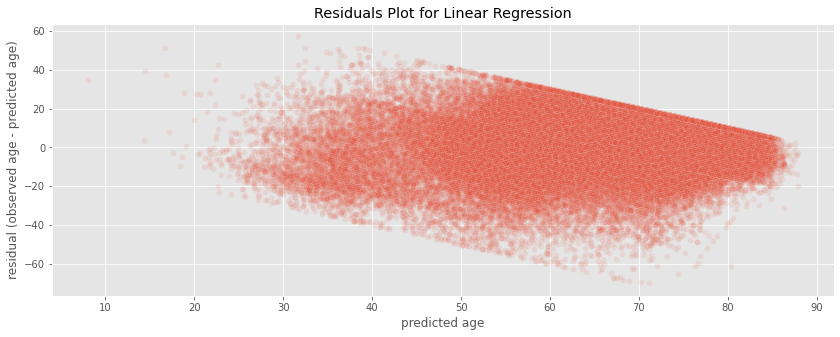

In [58]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.scatterplot(x=predict_train, y=y_train - predict_train, ax=ax, palette='Blues', alpha=0.1)
ax.set_xlabel('predicted age')
ax.set_ylabel('residual (observed age - predicted age)')
ax.set_title('Residuals Plot for Linear Regression');

#### Elastic Net Regressor

In [59]:
model_en = ElasticNetCV(random_state=42)

In [60]:
model_en.fit(X_train, y_train)

ElasticNetCV(random_state=42)

In [61]:
predict_train_en = model_en.predict(X_train)

In [62]:
predict_test_en = model_en.predict(X_test)

In [63]:
print('RMSE on Train Data with ElasticNet: ', mean_squared_error(y_train, predict_train_en))
print('R_squared on Train Data with ElasticNet: ', r2_score(y_train, predict_train_en))

print('RMSE on Test Data with ElasticNet: ', mean_squared_error(y_test, predict_test_en))
print('R_squared on Train Data with ElasticNet: ', r2_score(y_test, predict_test_en))

RMSE on Train Data with ElasticNet:  141.45171586046183
R_squared on Train Data with ElasticNet:  0.45339920322157823
RMSE on Test Data with ElasticNet:  141.1259249490894
R_squared on Train Data with ElasticNet:  0.46044489966771607


Text(0.5, 1.0, 'Actual v. Predicted Plot for ElasticNet Regressor Model')

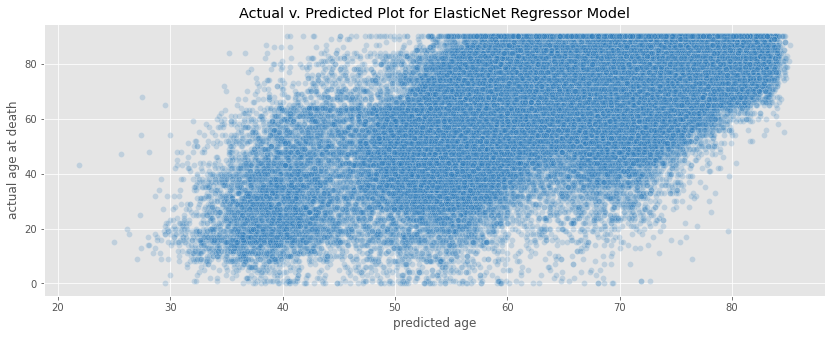

In [66]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.scatterplot(predict_train_en, y_train, ax=ax, alpha=0.2, color='#2b7bba');
ax.set_xlabel('predicted age')
ax.set_ylabel('actual age at death')
ax.set_title('Actual v. Predicted Plot for ElasticNet Regressor Model')

#### Random Forest Regressor

In [67]:
model_rf = RandomForestRegressor()

In [68]:
model_rf.fit(X_train, y_train)

RandomForestRegressor()

In [69]:
predict_train_rf = model_rf.predict(X_train)

In [70]:
predict_test_rf = model_rf.predict(X_test)

In [71]:
print('RMSE on Train Data with RF: ', mean_squared_error(y_train, predict_train_rf))
print('R_squared on Train Data with RF: ', r2_score(y_train, predict_train_rf))

print('RMSE on Test Data with RF: ', mean_squared_error(y_test, predict_test_rf))
print('R_squared on Train Data with RF: ', r2_score(y_test, predict_test_rf))

RMSE on Train Data with RF:  21.3337564851244
R_squared on Train Data with RF:  0.917561634214822
RMSE on Test Data with RF:  132.08306140628645
R_squared on Train Data with RF:  0.4950177334534881


In [72]:
pal = sns.color_palette("Blues")
print(pal.as_hex())

['#dbe9f6', '#bad6eb', '#89bedc', '#539ecd', '#2b7bba', '#0b559f']


/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Residuals Plot for Random Forest Regressor Model')

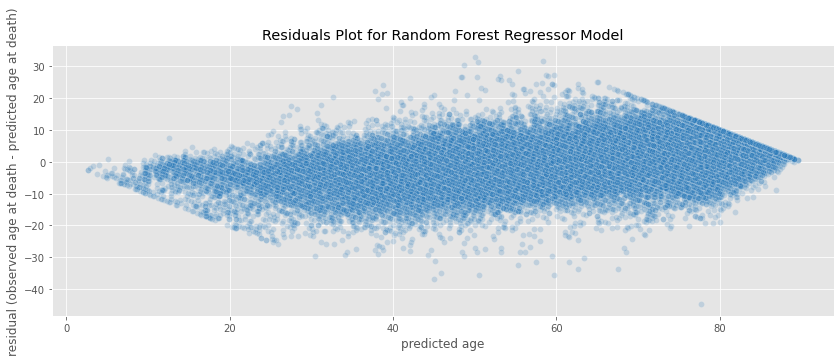

In [74]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.scatterplot(predict_train_rf, y_train - predict_train_rf, ax=ax, alpha=0.2, color='#2b7bba');
ax.set_xlabel('predicted age')
ax.set_ylabel('residual (observed age at death - predicted age at death)')
ax.set_title('Residuals Plot for Random Forest Regressor Model')

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Predicted v. Actual Plot for Random Forest Regressor Model, Training Set')

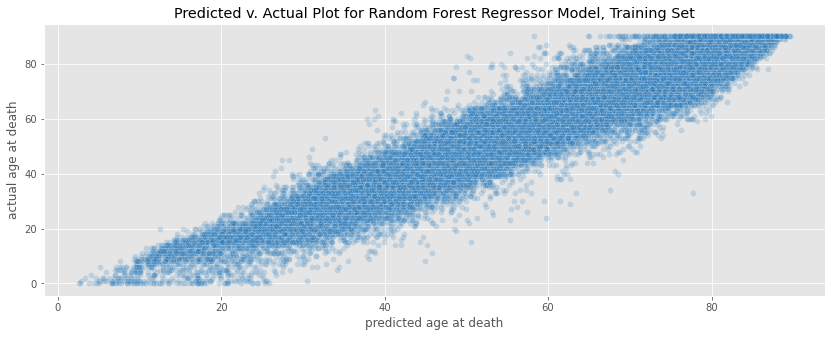

In [75]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.scatterplot(predict_train_rf, y_train, ax=ax, alpha=0.2, color='#2b7bba');
ax.set_xlabel('predicted age at death')
ax.set_ylabel('actual age at death')
ax.set_title('Predicted v. Actual Plot for Random Forest Regressor Model, Training Set')

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Predicted v. Actual Plot for Random Forest Regressor Model, Test Set')

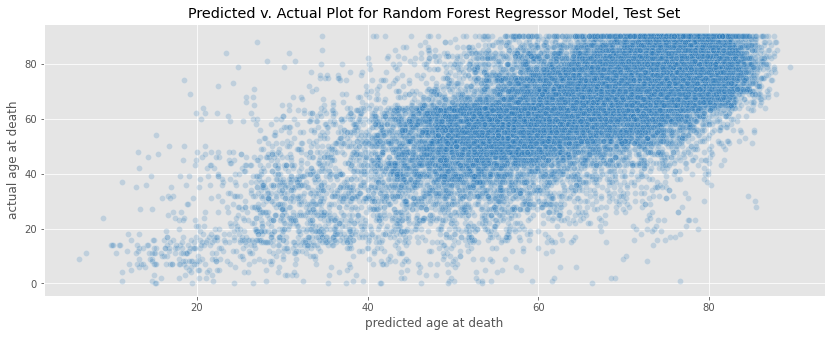

In [76]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.scatterplot(predict_test_rf, y_test, ax=ax, alpha=0.2, color='#2b7bba');
ax.set_xlabel('predicted age at death')
ax.set_ylabel('actual age at death')
ax.set_title('Predicted v. Actual Plot for Random Forest Regressor Model, Test Set')

In [77]:
mae_train = mean_absolute_error(y_train, predict_train_rf)
mae_test = mean_absolute_error(y_test, predict_test_rf)
print('MAE on Training Set: ', mae_train)
print('MAE on Test Set: ', mae_test)

MAE on Training Set:  3.373189759874937
MAE on Test Set:  8.506762225081763


In [78]:
from yellowbrick.regressor import ResidualsPlot

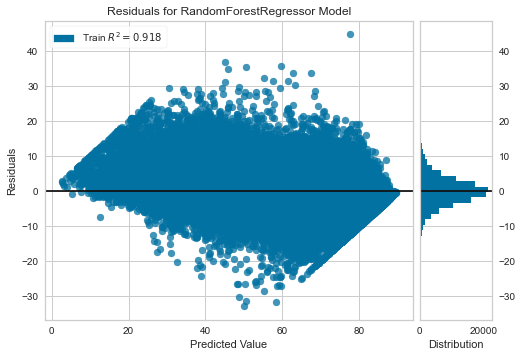

<AxesSubplot:title={'center':'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [79]:
visualizer = ResidualsPlot(model_rf)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
# visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show(alpha=0.1)  

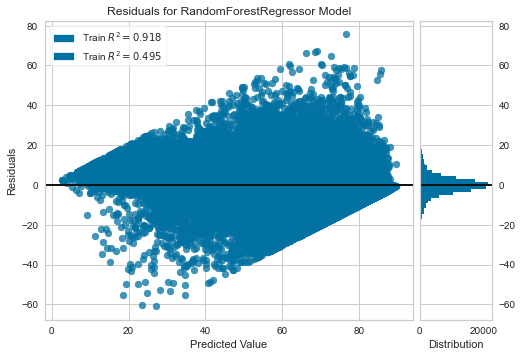

<AxesSubplot:title={'center':'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [80]:
visualizer.fit(X_test, y_test)  # Fit the training data to the visualizer
# visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show(alpha=0.1) 

In [81]:
feature_importances = pd.DataFrame(model_rf.fit(X_train, y_train).feature_importances_,
                                   index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)

In [82]:
feature_importances.head(20)

,importance
hitype_1.0,0.294741
povpct,0.077530
adjinc,0.070261
cause113_10.0,0.043842
cause113_11.0,0.039385
ssnyn_1.0,0.021040
tenure_2.0,0.020494
hosp_2.0,0.020327
sex_2.0,0.016100
urban_2.0,0.015608


Ask Noah tomorrow: 

Take out any features highly correlated with age and rerun. Maybe in a new / duplicate notebook in case it doesn't matter?

More than this?? 'ms', 'vt', 'esr', 'educ', 'wt'???